In [1]:
%%html
<svg height="300" width="600">
    <!-- arcs from hidden unit 1 to visible units -->
    <line x1="160" y1="50" x2="40" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="120" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="200" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="280" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="360" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="440" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    
    <!-- arcs from hidden unit 2 to visible units -->
    <line x1="320" y1="50" x2="40" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="120" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="200" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="280" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="360" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="440" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    
    <line x1="540" y1="120" x2="160" y2="50" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="320" y2="50" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="40" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="120" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="200" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="280" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="360" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="440" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    
    <!-- hidden units -->
    <circle cx="160" cy="50" r="20" stroke="red" stroke-width="2" fill="white" />
    <circle cx="320" cy="50" r="20" stroke="red" stroke-width="2" fill="white" />
    
    <text x="154" y="55"><tspan>h<tspan dy="5">1</tspan></tspan></text>
    <text x="314" y="55"><tspan>h<tspan dy="5">2</tspan></tspan></text>
    
    <!-- visible units-->
    <circle cx="40" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="120" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="200" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="280" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="360" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="440" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    
    <text x="34" y="200"><tspan>v<tspan dy="5">1</tspan></tspan></text>
    <text x="114" y="200"><tspan>v<tspan dy="5">2</tspan></tspan></text>
    <text x="194" y="200"><tspan>v<tspan dy="5">3</tspan></tspan></text>
    <text x="274" y="200"><tspan>v<tspan dy="5">4</tspan></tspan></text>
    <text x="354" y="200"><tspan>v<tspan dy="5">5</tspan></tspan></text>
    <text x="434" y="200"><tspan>v<tspan dy="5">6</tspan></tspan></text>
    
    <!-- bias unit -->
    <circle cx="540" cy="120" r="20" stroke="black" stroke-width="2" fill="white" />
    <text x="535" y="123"><tspan>b</tspan></text>
</svg> 

In [2]:
import numpy as np
from scipy.special import expit

np.random.seed(37)    

In [3]:
def get_weight_matrix(n_visible, n_hidden, mean=0.0, stdev=0.1):
    w = np.random.normal(loc=mean, scale=stdev, size=n_visible * n_hidden).reshape(n_visible, n_hidden)
    c = np.zeros((n_visible, 1))
    r = np.zeros((1, n_hidden + 1))
    m = np.hstack([c, w])
    m = np.vstack([r, m])
    return m

def get_data_matrix(data):
    c = np.ones((data.shape[0], 1))
    m = np.hstack([c, data])
    return m

def positive_contrastive_divergence(X, W):
    ph_activations = X.dot(W)
    ph_probs = expit(ph_activations)
    ph_probs[:, 0] = 1.0
    ph_states = ph_probs > np.random.rand(ph_probs.shape[1])
    p_associations = X.T.dot(ph_probs)
    return ph_states, p_associations

def negative_contrastive_divergence(ph_states, W):
    nv_activations = ph_states.dot(W.T)
    nv_probs = expit(nv_activations)
    nv_probs[:, 0] = 1.0
    nh_activations = nv_probs.dot(W)
    nh_probs = expit(nh_activations)
    n_associations = nv_probs.T.dot(nh_probs)
    return nv_probs, n_associations

def update_weights(n, p_associations, n_associations, W, lr=0.1):
    M = W + lr * ((p_associations - n_associations) / float(n))
    return M

def query_hidden(v, n_hidden, W):
    n = v.shape[0]
    h_states = np.ones((n, n_hidden + 1))
    d = np.hstack([np.ones((n, 1)), v])
    h_activations = d.dot(W)
    h_probs = expit(h_activations)
    h_states[:,:] = h_probs > np.random.rand(n, n_hidden + 1)
    return h_states[:,1:]

def query_visible(h, n_visible, W):
    n = h.shape[0]
    v_states = np.ones((n, n_visible + 1))
    d = np.hstack([np.ones((n, 1)), h])
    v_activations = d.dot(W.T)
    v_probs = expit(v_activations)
    v_states[:,:] = v_probs > np.random.rand(n, n_visible + 1)
    return v_states[:,1:]

def daydream(n_samples, n_visible, n_hidden, W):
    samples = np.ones((n_samples, n_visible + 1))
    samples[0,1:] = np.random.rand(n_visible)
    
    for i in range(1, n_samples):
        visible = samples[i-1,:]
        h_activations = visible.dot(W)
        h_probs = expit(h_activations)
        h_states = h_probs > np.random.rand(n_hidden + 1)
        h_states[0] = 1
        
        v_activations = h_states.dot(W.T)
        v_probs = expit(v_activations)
        v_states = v_probs > np.random.rand(n_visible + 1)
        
        samples[i, :] = v_states
    
    return samples[-1, :]

In [4]:
X = get_data_matrix(np.array([
    [1,1,1,0,0,0],
    [1,0,1,0,0,0],
    [1,1,1,0,0,0],
    [0,0,1,1,1,0],
    [0,0,1,1,0,0],
    [0,0,1,1,1,0]]))

In [5]:
n_visible = 6
n_hidden = 2
W = get_weight_matrix(n_visible, n_hidden)

In [6]:
from tqdm import tqdm
import pandas as pd

def train(X, W):
    loss_trace = []
    for epoch in tqdm(range(5000)):
        ph_states, p_associations = positive_contrastive_divergence(X, W)
        nv_probs, n_associations = negative_contrastive_divergence(ph_states, W)
        W = update_weights(X.shape[0], p_associations, n_associations, W)

        error = np.sum((X - nv_probs) ** 2)
        t = (epoch, error)
        loss_trace.append(t)
    loss_df = pd.DataFrame(data=loss_trace, columns=['epoch', 'loss'])
    return W, loss_df

In [7]:
W, loss = train(X, W)
print(W)

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 22123.89it/s]


[[ 2.53037996  2.45858985  0.0810972 ]
 [-0.22471573 -3.92533273  7.42939654]
 [ 0.35109567 -6.92624773  3.05664351]
 [ 4.93552312  4.06165019  1.75982293]
 [ 0.16666718  4.31462577 -7.89124389]
 [-0.91730461  1.5951622  -5.34173176]
 [-4.06156083 -2.54953871 -2.38364613]]


Text(0,0.5,'loss')

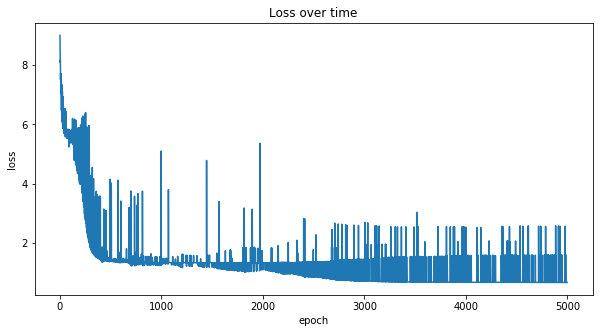

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(loss['epoch'], loss['loss'])
ax.set_title('Loss over time')
ax.set_xlabel(r'epoch')
ax.set_ylabel(r'loss')

In [9]:
query_hidden(np.array([[0,0,0,1,1,0]]), n_hidden, W)

array([[1., 0.]])

In [10]:
query_hidden(np.array([[1,1,0,0,0,0]]), n_hidden, W)

array([[0., 1.]])

In [11]:
query_visible(np.array([[1,0]]), n_visible, W)

array([[0., 0., 1., 1., 1., 0.]])

In [12]:
query_visible(np.array([[0,1]]), n_visible, W)

array([[1., 1., 1., 0., 0., 0.]])

In [16]:
for i in range(10):
    print(daydream(500, n_visible, n_hidden, W))

[1. 0. 0. 1. 1. 1. 0.]
[1. 1. 1. 1. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0.]
[1. 0. 0. 1. 1. 0. 0.]
[1. 1. 0. 1. 0. 0. 0.]
[1. 0. 0. 1. 1. 1. 0.]
[1. 1. 1. 1. 0. 0. 0.]
[1. 0. 0. 1. 1. 1. 0.]
[1. 1. 0. 1. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0.]


# References

* [Introduction to Restricted Boltzmann Machines](http://blog.echen.me/2011/07/18/introduction-to-restricted-boltzmann-machines/)
* [Dreaming of names with RBMs](http://colinmorris.github.io/blog/dreaming-rbms)
* [A Practical guide to training restricted Boltzmann machines](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
* [Geometry of the Restricted Boltzmann Machine](http://arxiv.org/abs/0908.4425)